In [4]:
import torch
from vae import VariationalAutoencoder
PATH = "model.pt"

latent_dims = 10
granularity = 0.01

model = VariationalAutoencoder(
        int(1./granularity)**2, latent_dims, 1)
model.load_state_dict(torch.load(PATH))
model.eval()



VariationalAutoencoder(
  (encoder): Encoder(
    (fc_mu): Sequential(
      (0): Linear(in_features=10000, out_features=10, bias=True)
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=10000, out_features=10, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=14, out_features=10000, bias=True)
      (1): Sigmoid()
    )
  )
)

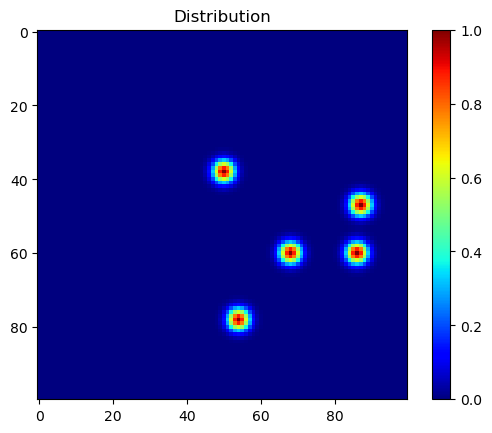

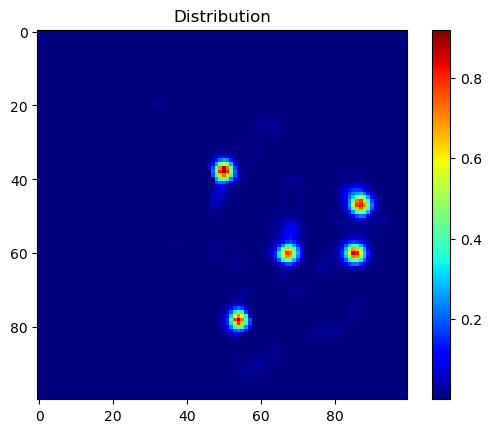

tensor([[ 1.8504, -0.3455, -0.6916,  0.8749, -0.4974,  0.6857,  1.2356,  0.9182,
         -0.5818,  1.0651]], grad_fn=<AddmmBackward0>) tensor([[-2.4831, -2.5893, -5.1558, -3.0946, -2.6274, -3.8528, -5.2928, -2.9127,
         -3.6262, -3.0689]], grad_fn=<AddmmBackward0>)


In [23]:
from dataset import MyDataset
from torch.utils.data import DataLoader
from utlis_ import Distribution
from sklearn.model_selection import train_test_split

latent_dims = 100
granularity = 0.01
dataset = MyDataset(csv_file="merged.csv",
                    distributionGranurality=granularity)

train_dataset, test_dataset = train_test_split(
    dataset, test_size=0.2, random_state=42)

test_dataset = DataLoader(
    test_dataset, batch_size=1, shuffle=True)

sample = next(iter(test_dataset))
x = sample["distribution"]
x = x.view(-1, x.size(1)**2)
t = sample["team"]
bp = sample["ballPosition"]
bc = sample["ballControl"]

x_hat, mu, logvar = model(x, t, bp, bc)
x_hat = x_hat.view(100, 100).detach().numpy()
x = x.view(100,100)


Distribution.plot(x)
Distribution.plot(x_hat)

print(mu, logvar)

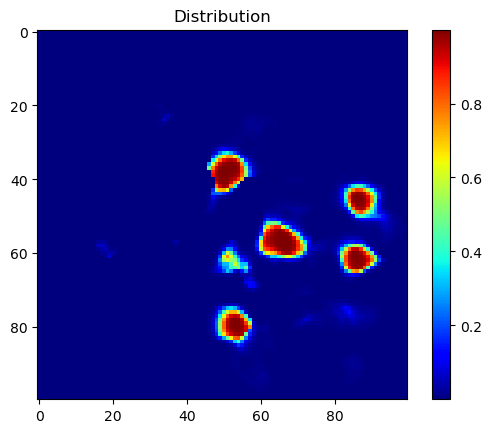

In [27]:

logvar = torch.rand_like(logvar)
mu = torch.rand_like(mu)
std = torch.exp(0.5 * logvar)
z = torch.randn_like(std) * std + mu
x_perturb = model.decoder(z, t, bp, bc)
x_perturb = x_perturb.view(100, 100).detach().numpy()

Distribution.plot(x_perturb)